## Exploratory Data Analysis
This notebook's objective is to explore the data and to serve as a development lab for the models

In [1]:
from google.oauth2 import service_account
import pandas as pd
from skopt import BayesSearchCV
import json
import pandas_gbq
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from src.initial_ingestion import load_data
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import warnings
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
import scipy.stats as stats
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)

Extracting the data from Google BigQuery is the first step here. The functions below were built in a way to optimize the time it takes to complete the extraction (all considering we have Bigquery simple sandbox solution).


In [77]:

def get_bq_data_chunk(query, credentials):
    return pandas_gbq.read_gbq(query, credentials=credentials, dialect="standard")

def get_bq_data(tb_id, sub_db, num_chunks=4):
    service_account_info = json.load(open('GBQ.json'))
    credentials = service_account.Credentials.from_service_account_info(service_account_info)
    
    # Define your base query with a subquery to compute row numbers first
    base_query = f"""
    SELECT * FROM (
        SELECT *, ROW_NUMBER() OVER() as row_num 
        FROM db_bank_{sub_db}.{tb_id}
    ) WHERE MOD(row_num, {num_chunks}) = {{}}
    """
    
    # Create a list of queries for each chunk
    queries = [base_query.format(i) for i in range(num_chunks)]
    
    # Use ThreadPoolExecutor to run queries in parallel
    with ThreadPoolExecutor(max_workers=num_chunks) as executor:
        futures = [executor.submit(get_bq_data_chunk, query, credentials) for query in queries]
    
    # Combine the results from all chunks
    results = [future.result() for future in futures]
    df = pd.concat(results, ignore_index=True)

    df.drop(columns=["row_num"], inplace=True)

    return df


In [ ]:
df = get_bq_data(tb_id = "train", sub_db = "original_datasets")

In [15]:
df_train = df.copy()

In [16]:
def train_test_export(df_train):

    X = df_train.drop(["target"], axis=1)
    y = df_train[["target"]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=df_train["target"])

    df_train_new = pd.concat([X_train, y_train], axis=1)
    df_test_new = pd.concat([X_test, y_test], axis=1)

    load_data([(df_train_new, 'train'), (df_test_new, 'test')], 'experiments')


In [17]:
train_test_export(df_train)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [53]:
df = get_bq_data(tb_id = "train", sub_db = "experiments")

Downloading:   0%|          |




Downloading:  14%|█▍        |



Downloading:  28%|██▊       |




Downloading:  42%|████▏     |



Downloading:  56%|█████▋    |




Downloading:  56%|█████▋    |


Downloading:  71%|███████   |


Downloading:  71%|███████   |


Downloading:  85%|████████▍ |





Downloading: 100%|██████████|





Downloading: 100%|██████████|
Downloading: 100%|██████████|


Downloading: 100%|██████████|


In [30]:
df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,train_68689,12.9626,0.5352,9.9696,5.7693,10.4241,-5.2269,4.8468,15.3162,3.6921,7.087,9.0255,-14.2294,13.9659,7.32,10.3792,14.3191,11.4739,-4.7259,7.2145,22.4503,12.8452,13.2301,6.5651,1.8725,8.386,13.4401,-11.0731,0.7966,5.0378,1.3529,0.2374,12.3414,-1.2099,16.1049,10.6377,12.7193,2.4407,8.9684,5.2643,7.9724,-1.3671,2.7772,10.6551,11.7658,13.0671,-34.431,6.3005,-29.5138,31.2887,15.3476,12.713,6.0592,-5.2546,6.8267,-13.496,23.4113,14.231,6.0652,3.9796,10.0998,8.6159,3.2235,0.4764,-1.7919,7.0645,0.2977,6.4941,14.1976,5.01,-10.3708,30.7337,0.7888,0.1568,39.1586,16.1109,17.2165,10.0286,17.1209,5.9926,14.6582,3.3166,13.6083,5.5495,17.6743,-9.0543,22.7959,-0.1403,8.7005,5.2226,2.523,-16.9872,7.0673,6.4546,11.2935,6.877,1.219,9.9495,5.4477,1.4459,-4.1809,-6.1698,19.2351,29.0768,1.654,13.9389,3.3275,7.8981,10.9401,14.4017,25.5656,14.6387,5.5497,4.1004,11.665,3.2536,2.1755,3.7677,6.0227,-1.0805,1.1086,21.4875,10.3533,-12.405,4.8302,3.575,11.8408,12.9597,-2.9537,0.3112,12.5057,12.1649,0.24,7.2263,6.4273,-15.5949,-12.3314,11.1058,30.4383,7.1956,15.0889,2.1507,7.5496,20.7387,13.9187,7.8209,11.576,13.8334,-12.2427,3.7744,-6.1771,15.2629,11.9755,3.7943,14.7158,10.5868,-5.7952,15.3421,-4.1968,12.0291,5.132,4.1534,5.5269,5.149,7.0494,-8.1728,16.6105,2.5645,-4.4114,8.8476,5.8393,8.7002,2.5838,26.3088,4.5104,18.7413,16.076,-2.7265,11.1535,-5.2297,3.3559,-3.1639,7.878,-3.5895,13.6237,16.6951,-12.2205,13.2948,-21.9701,14.7048,0.7966,7.5335,1.4976,0.6317,5.9958,17.5636,0.9956,-4.4458,8.3736,19.1155,-13.6286,0
1,train_96370,11.4434,-2.1199,5.5819,7.983,11.1549,-5.0728,6.3599,12.7641,-0.1248,9.4526,8.6441,-4.0447,14.1428,4.0444,5.7045,14.6126,14.8804,-8.5348,18.6363,4.2654,8.839,9.3894,3.5968,2.9333,16.8203,13.0874,-14.5728,-0.8419,5.3085,6.7968,1.1885,13.2587,0.1132,8.6077,11.0981,4.3742,-0.3895,7.2983,5.0948,-6.2585,-15.6801,12.4786,12.1946,11.6216,10.5599,-12.2218,12.0078,-13.1298,14.9572,11.7836,13.0229,3.3035,-2.8646,6.6235,14.5274,11.2891,18.367,7.2876,-3.7387,8.1217,11.8893,-30.8596,2.4072,-2.8087,5.642,-9.5285,5.1116,12.0123,5.01,-2.7612,17.4639,0.2523,-3.0462,26.2489,0.0603,9.4916,11.4392,19.7408,3.8367,13.0409,2.4872,15.3699,-18.9389,11.34,-13.0599,20.3794,4.519,16.4863,7.1123,1.1267,-18.6421,7.148,11.2018,10.6551,13.1306,-0.8833,12.8644,3.6791,1.0086,-3.2382,-18.9055,10.6471,30.7163,1.2594,11.2687,4.2851,10.5226,29.2924,14.5558,10.6448,6.0329,6.7202,3.1666,16.1499,2.0245,2.1716,1.5567,2.6731,-4.3945,1.0602,26.9867,14.3953,1.7506,-6.3519,5.8947,12.1812,14.2125,

In [33]:
df.isnull().sum().sum()

0

In [34]:
df.duplicated().sum()

52157

In [54]:
df.drop_duplicates(inplace=True)

In [36]:
df["target"].value_counts()

target
0    79082
1     8761
Name: count, dtype: int64

In [55]:
X = df.drop(["target"], axis=1)
y = df[["target"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=df["target"])

perc_original = (df[["target"]].value_counts()[0] / (df[["target"]].value_counts()[0] + df[["target"]].value_counts()[1]))*100
perc_train = (y_train.value_counts()[0] / (y_train.value_counts()[0] + y_train.value_counts()[1]))*100
perc_test = (y_test.value_counts()[0] / (y_test.value_counts()[0] + y_test.value_counts()[1]))*100

print(f"Prop. of customers that did not make the transaction on original data: {perc_original:.02f}, associated with the values (0/1): {df[['target']].value_counts()[0]} / {df[['target']].value_counts()[1]}")
print(f"Prop. of customers that did not make the transaction on training data: {perc_train:.02f}, associated with the values (0/1): {y_train.value_counts()[0]} / {y_train.value_counts()[1]}")
print(f"Prop. of customers that did not make the transaction on testing data: {perc_test:.02f}, associated with the values (0/1): {y_test.value_counts()[0]} / {y_test.value_counts()[1]}")

Prop. of customers that made the transaction on original data: 90.03, associated with the values (0/1): 79082 / 8761
Prop. of customers that made the transaction on training data: 90.03, associated with the values (0/1): 67219 / 7447
Prop. of customers that made the transaction on testing data: 90.03, associated with the values (0/1): 11863 / 1314


In [62]:
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)
training_data.to_csv(r"C:\Users\artur\Documents\bank-challenge-ml-project\training_data_nb.csv", index_label=False)
testing_data.to_csv(r"C:\Users\artur\Documents\bank-challenge-ml-project\testing_data_nb.csv", index_label=False)

In [78]:
df = pd.read_csv(r"C:\Users\artur\Documents\bank-challenge-ml-project\training_data_nb.csv")

In [80]:
df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
37278,train_180762,7.2034,3.4085,14.1904,9.8206,8.6931,-13.2810,3.6754,15.3837,0.5461,7.4611,-0.4744,3.0146,13.9537,4.5433,6.2170,14.5102,7.0624,-0.3825,10.7959,23.0675,11.8837,15.4010,2.8017,2.5566,10.8731,13.8371,-2.5993,-3.0964,5.4131,0.5435,7.4319,5.9253,-2.7001,17.2878,11.4637,8.1315,1.8573,3.2877,11.3518,0.5615,-18.4594,-3.3657,11.9759,11.6889,13.7080,-45.5802,8.9995,-29.1486,4.3943,12.7624,13.6867,9.0145,-4.9539,4.8399,14.8546,4.3356,14.5736,5.5787,1.4079,7.9454,9.8755,5.9549,-0.0211,0.7627,3.4962,2.5424,7.1956,5.4421,5.0212,0.6884,36.4322,1.0468,2.7910,16.6317,23.3358,10.6254,13.3431,16.3136,4.2957,15.9940,11.1467,16.6501,-15.3551,8.9716,-5.9346,18.9860,6.5359,16.8444,3.4522,1.0002,-11.4158,6.8202,14.4701,10.4051,11.1380,0.0571,24.9830,26.0638,1.7718,0.0899,6.4652,10.4336,24.1121,1.3693,9.0177,5.0440,8.5961,16.5064,14.3128,19.8771,2.7222,5.9442,5.7537,8.1804,1.9244,2.0922,-0.9937,20.6862,-8.7232,9.3083,34.2432,8.5926,6.0139,18.3984,4.8866,12.6527,13.2852,3.0662,0.3005,12.1538,11.4788,0.2784,9.8259,7.2572,-5.9853,4.1518,44.1292,21.5453,3.9687,8.9951,-0.5251,-2.2227,16.9587,15.4659,7.5438,5.9634,8.4609,0.9562,4.0095,29.5231,19.0308,12.7528,7.1795,18.8759,4.5452,1.1838,13.8546,0.5556,24.7511,6.3691,13.7153,5.2967,5.4141,5.9600,-0.0768,20.5900,2.8692,7.1250,0.4362,5.4099,2.4149,-3.4932,31.5905,-1.3055,25.9760,13.5320,-7.2455,11.5547,-15.4201,3.6174,7.1300,13.2589,-2.1007,9.7488,12.8539,-1.5698,11.1829,-26.5673,10.1272,2.7100,-6.5436,5.8068,2.1347,7.6764,17.3630,-0.0254,0.8003,7.8159,8.8018,0.0283,0
77158,train_144338,7.7460,-3.3427,6.8532,8.8169,8.9721,1.5590,5.0130,20.9155,2.1664,9.3064,3.2360,-3.3313,14.0867,12.8052,10.1194,13.8013,9.5310,-2.9844,20.4258,0.8152,11.1942,19.8642,3.9582,2.6183,7.7341,13.8955,-2.1639,-0.8894,5.2658,6.7290,-4.2280,8.1584,2.0112,17.8661,11.3608,6.5306,2.8734,3.6015,9.9374,6.8141,-18.3337,15.2508,12.1561,11.1071,9.1904,-6.0125,14.5611,-6.3671,23.4988,17.8119,12.3411,7.6801,-11.8341,6.4064,-1.0489,9.2250,14.8119,6.8343,-0.7201,7.8839,12.9475,-10.8075,2.8877,4.7412,7.6015,3.6390,6.2081,0.0859,5.0180,-0.6794,29.2263,0.6335,-0.1672,13.6449,21.7530,20.8341,4.1936,22.8031,6.5111,13.8503,1.2604,13.1899,-8.4132,-0.1711,2.2590,16.5308,6.7204,17.1952,8.3054,5.9658,-21.7954,7.0488,13.8137,10.1707,12.9663,0.2899,27.7425,36.1610,2.1303,-1.2053,-13.2050,12.4301,11.5732,1.4180,7.8530,4.7996,7.7978,7.1450,14.2506,11.6992,6.0159,6.3682,3.1613,1.1196,2.6956,-1.8647,3.2341,12.2688,10.2722,-2.2142,28.6362,13.7792,-2.5587,14.8743,2.1761,1

In [65]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
var_0,74666.0,10.675824,3.050254,0.5979,8.437125,10.52040,12.765375,20.3150
var_1,74666.0,-1.614067,4.054223,-13.8674,-4.725875,-1.59590,1.376050,10.3768
var_2,74666.0,10.716085,2.645625,2.3134,8.718925,10.57815,12.529500,19.3530
var_3,74666.0,6.796522,2.045412,0.3736,5.253400,6.82425,8.325150,12.9918
var_4,74666.0,11.075962,1.626043,5.2778,9.874100,11.10750,12.264775,16.0448
...,...,...,...,...,...,...,...,...
var_196,74666.0,2.293090,5.446804,-14.0204,-1.972450,2.41715,6.551600,18.3215
var_197,74666.0,8.907773,0.922240,5.9606,8.254000,8.88780,9.590575,12.0004
var_198,74666.0,15.866148,3.004570,6.2993,13.829850,15.92275,18.053100,26.0346
var_199,74666.0,-3.337866,10.409441,-37.6962,-11.221075,-2.78615,4.796925,27.5340


In [4]:
df.drop(columns=["ID_code"], inplace=True)

In [68]:
df_rel = df
features = list(df_rel.columns)
features.remove('target')

mms = MinMaxScaler()

df_rel[features] = mms.fit_transform(df_rel[features])

In [73]:
corr_matrix = df_rel.corr(method='spearman')

# Convert the correlation matrix to a long format DataFrame
corr_df = corr_matrix.stack().reset_index()
corr_df.columns = ["Feature A", "Feature B", "Correlation"]

corr_df["p-value"] = [stats.spearmanr(df_rel[feat_a], df_rel[feat_b])[1] for feat_a, feat_b in zip(corr_df["Feature A"], corr_df["Feature B"])]

corr_df_filtered = corr_df.loc[(abs(corr_df["Correlation"]) >= 0.5) & (corr_df["Feature A"] != "target") & (corr_df["Feature B"] != "target")]
corr_df_filtered = corr_df_filtered.drop_duplicates(subset=["Correlation"]).loc[corr_df_filtered["Correlation"] < 1]
corr_df_filtered["p-value"] = corr_df_filtered["p-value"].apply(lambda x: "{:.4f}".format(x))
corr_df_filtered

,Feature A,Feature B,Correlation,p-value


In [79]:
corr_df.loc[(corr_df["Correlation"] < 1) & (corr_df["Feature A"] != "target") & (corr_df["Feature B"] != "target")].sort_values(by=["Correlation"], ascending=False).head()

,Feature A,Feature B,Correlation,p-value
1363,var_6,var_157,0.014332,0.000090
31563,var_157,var_6,0.014332,0.000090
28489,var_141,var_148,0.013881,0.000149
29889,var_148,var_141,0.013881,0.000149
8105,var_40,var_65,0.013626,0.000197


In [22]:
X = df.drop(columns=["target"])
y = df["target"]

In [ ]:
comb_vector = []
metrics_vector = []

ratio = float(y.value_counts()[0] / y.value_counts()[1])

for i in range(5):
    j = i + 1
    print("===============")
    rfe = RFE(
        estimator            = xgb.XGBClassifier(scale_pos_weight=ratio), 
        n_features_to_select = int(len(X.columns)/j)
    )
    print(f"start fitting RFE for {int(len(X.columns)/j)} features")
    rfeFit = rfe.fit (
        X = X, 
        y = y
    )
    print(f"finish fitting RFE for {int(len(X.columns)/j)} features")

    j_features = list(X.columns[rfeFit.support_])
    comb_vector.append(j_features)

    kfold = StratifiedKFold(n_splits = 3)
    print(f"start fitting cv for {int(len(X.columns)/j)} features")

    cv_results = cross_val_score(xgb.XGBClassifier(scale_pos_weight=ratio), X[j_features], y, cv = kfold, scoring = 'roc_auc')
    print(f"finish fitting cv for {int(len(X.columns)/j)} features")

    metrics_vector.append(np.mean(np.array(cv_results)))

    print("===============")

In [ ]:
rfe_results = pd.DataFrame(dict(zip([int(len(X.columns)/j) for j in range(1, 6)], metrics_vector)), columns=['n_features', 'mean_roc_auc'])

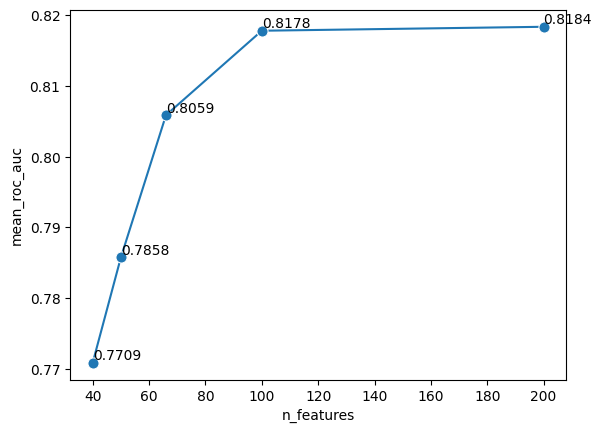

In [41]:
ax = sns.lineplot(x="n_features", y="mean_roc_auc", data=rfe_results, marker='o', markersize=8)
for i, row in rfe_results.iterrows():
    ax.text(row['n_features'], row['mean_roc_auc'], f'{row["mean_roc_auc"]:.4f}', color='black', ha='left', va='bottom')

plt.show()


In [108]:
features_json = dict(zip([int(len(X.columns)/j) for j in range(1, 6)], comb_vector))

In [111]:
with open("rfe_results.json", "w") as json_file:
        json.dump(features_json, json_file)

In [67]:
features_json = json.load(open('rfe_results.json'))

In [122]:
x_input = df[features_json["100"]]
y_output = df['target']

ratio = float(y_output.value_counts()[0]) / y_output.value_counts()[1]

k = 3

kf = StratifiedKFold(n_splits=k)

models = {
    "RandomForestClassifier": RandomForestClassifier(class_weight='balanced', n_jobs=-1), #class_weight as balanced due to extremely imbalanced classes (1 and 0)
    "LightGBMClassifier": LGBMClassifier(verbose=-1, scale_pos_weight=ratio), #giving more weight to positive instances due to imbalance
    "XGBoostClassifier": XGBClassifier(scale_pos_weight=ratio), #giving more weight to positive instances due to imbalance
    "SVMClassifier": SVC(class_weight='balanced'), #class_weight as balanced due to extremely imbalanced classes (1 and 0)
    "DecisionTreeClassifier": DecisionTreeClassifier(class_weight='balanced') #class_weight as balanced due to extremely imbalanced classes (1 and 0)
}

model_metrics = {}

for model_name, model in models.items():
    fold_metrics = {
        "F1-Score": [],
        "Precision": [],
        "ROC_AUC": [],
        "Recall": []
    }

    for train_index, val_index in kf.split(x_input, y=y_output):
        X_train_fold, X_val_fold = x_input.iloc[train_index], x_input.iloc[val_index]
        y_train_fold, y_val_fold = y_output.iloc[train_index], y_output.iloc[val_index]

        mme = MinMaxScaler()

        X_train_fold = mme.fit_transform(X_train_fold)
        X_val_fold = mme.transform(X_val_fold)

        model.fit(X_train_fold, y_train_fold.values.ravel())
        y_pred = model.predict(X_val_fold)

        f1 = f1_score(y_val_fold, y_pred)
        precision = precision_score(y_val_fold, y_pred)
        roc_auc = roc_auc_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)

        fold_metrics["F1-Score"].append(f1)
        fold_metrics["Precision"].append(precision)
        fold_metrics["ROC_AUC"].append(roc_auc)
        fold_metrics["Recall"].append(recall)

    mean_metrics = {
        "F1-Score": [np.mean(fold_metrics["F1-Score"]), np.std(fold_metrics["F1-Score"], ddof=1)] ,
        "Precision": [np.mean(fold_metrics["Precision"]), np.std(fold_metrics["Precision"], ddof=1)],
        "ROC_AUC": [np.mean(fold_metrics["ROC_AUC"]), np.std(fold_metrics["ROC_AUC"], ddof=1)],
        "Recall": [np.mean(fold_metrics["Recall"]), np.std(fold_metrics["Recall"], ddof=1)]
    }

    model_metrics[model_name] = mean_metrics

In [123]:
model_metrics

{'RandomForestClassifier': {'F1-Score': [0.0, 0.0],
  'Precision': [0.0, 0.0],
  'ROC_AUC': [0.5, 0.0],
  'Recall': [0.0, 0.0]},
 'LightGBMClassifier': {'F1-Score': [0.4590335202225169, 0.003437597671033919],
  'Precision': [0.34879284722909576, 0.005357955592193029],
  'ROC_AUC': [0.7662395144233498, 0.003474771668596464],
  'Recall': [0.6714129353847366, 0.010930701424718364]},
 'XGBoostClassifier': {'F1-Score': [0.4375143244709518, 0.002811053744425554],
  'Precision': [0.4392242391942456, 0.0074040891237024935],
  'ROC_AUC': [0.6871007633700824, 0.0003564010339336404],
  'Recall': [0.43588050637972375, 0.001856470944138408]},
 'SVMClassifier': {'F1-Score': [0.4774586498332893, 0.0038446817416517977],
  'Precision': [0.4060273788570137, 0.004305897513331818],
  'ROC_AUC': [0.7427556356407045, 0.0027044800625558077],
  'Recall': [0.5794281587532258, 0.005787921911506507]},
 'DecisionTreeClassifier': {'F1-Score': [0.1643522361116834,
   0.002543926153483433],
  'Precision': [0.1604004

In [155]:
with open("cv_results.json", "w") as json_file:
        json.dump(model_metrics, json_file)

In [4]:
model_metrics = json.load(open('cv_results.json'))

In [157]:
model_metrics

{'RandomForestClassifier': {'F1-Score': [0.0, 0.0],
  'Precision': [0.0, 0.0],
  'ROC_AUC': [0.5, 0.0],
  'Recall': [0.0, 0.0]},
 'LightGBMClassifier': {'F1-Score': [0.4590335202225169, 0.003437597671033919],
  'Precision': [0.34879284722909576, 0.005357955592193029],
  'ROC_AUC': [0.7662395144233498, 0.003474771668596464],
  'Recall': [0.6714129353847366, 0.010930701424718364]},
 'XGBoostClassifier': {'F1-Score': [0.4375143244709518, 0.002811053744425554],
  'Precision': [0.4392242391942456, 0.0074040891237024935],
  'ROC_AUC': [0.6871007633700824, 0.0003564010339336404],
  'Recall': [0.43588050637972375, 0.001856470944138408]},
 'SVMClassifier': {'F1-Score': [0.4774586498332893, 0.0038446817416517977],
  'Precision': [0.4060273788570137, 0.004305897513331818],
  'ROC_AUC': [0.7427556356407045, 0.0027044800625558077],
  'Recall': [0.5794281587532258, 0.005787921911506507]},
 'DecisionTreeClassifier': {'F1-Score': [0.1643522361116834,
   0.002543926153483433],
  'Precision': [0.1604004

In [5]:
rows = []

for model, metrics in model_metrics.items():
    for metric, value in metrics.items():
        rows.append([model, metric, value[0], value[1]])

metrics_df = pd.DataFrame(rows, columns=['Model name', 'Metric name', 'Metric Mean value', 'Metric Std value'])

In [162]:
metrics_df

,Model name,Metric name,Metric Mean value,Metric Std value
0,RandomForestClassifier,F1-Score,0.000000,0.000000
1,RandomForestClassifier,Precision,0.000000,0.000000
2,RandomForestClassifier,ROC_AUC,0.500000,0.000000
3,RandomForestClassifier,Recall,0.000000,0.000000
4,LightGBMClassifier,F1-Score,0.459034,0.003438
5,LightGBMClassifier,Precision,0.348793,0.005358
6,LightGBMClassifier,ROC_AUC,0.766240,0.003475
7,LightGBMClassifier,Recall,0.671413,0.010931
8,XGBoostClassifier,F1-Score,0.437514,0.002811
9,XGBoostClassifier,Precision,0.439224,0.007404


In [161]:
Metric_see = 'ROC_AUC'

metrics_df.loc[metrics_df["Metric name"] == Metric_see].sort_values(by=["Metric Mean value"], ascending=False)

,Model name,Metric name,Metric Mean value,Metric Std value
6,LightGBMClassifier,ROC_AUC,0.766240,0.003475
14,SVMClassifier,ROC_AUC,0.742756,0.002704
10,XGBoostClassifier,ROC_AUC,0.687101,0.000356
18,DecisionTreeClassifier,ROC_AUC,0.535384,0.001570
2,RandomForestClassifier,ROC_AUC,0.500000,0.000000


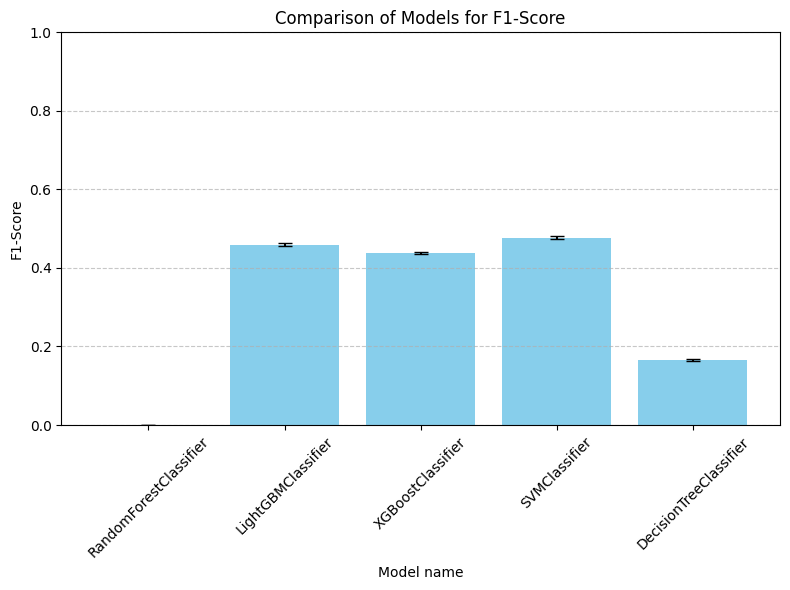

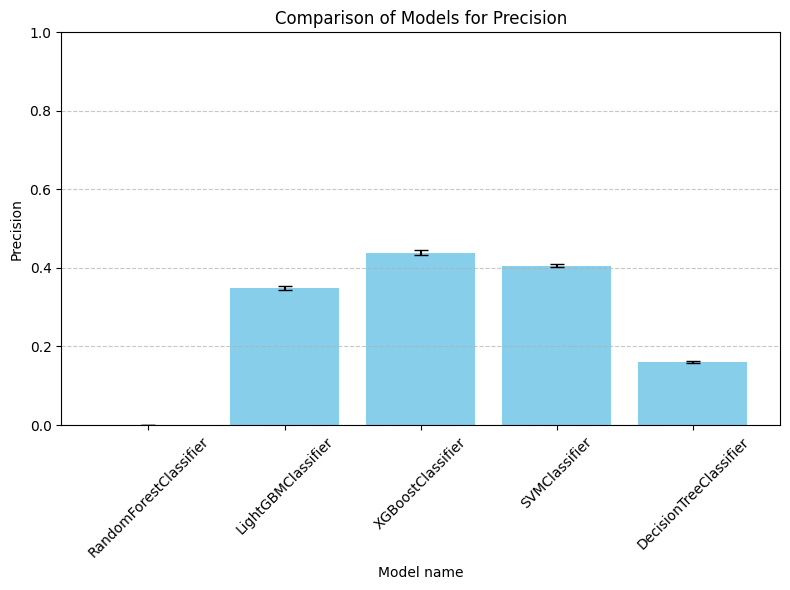

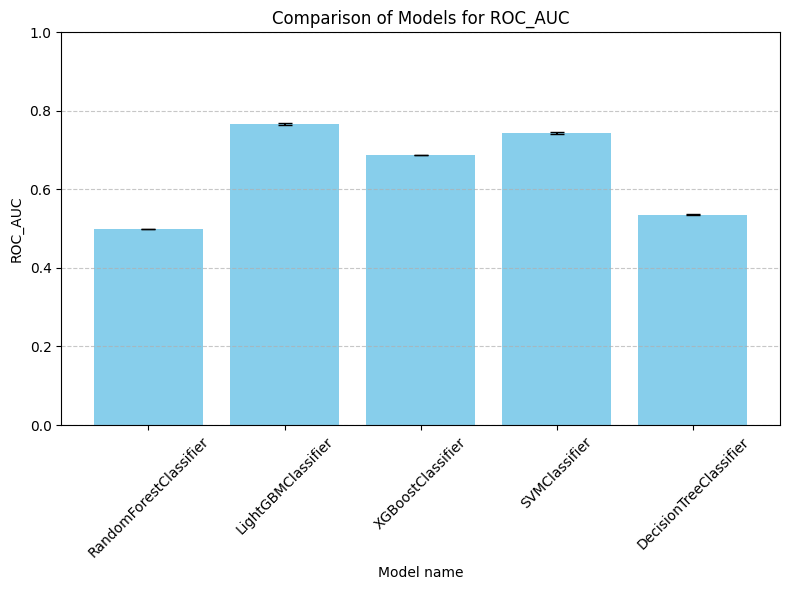

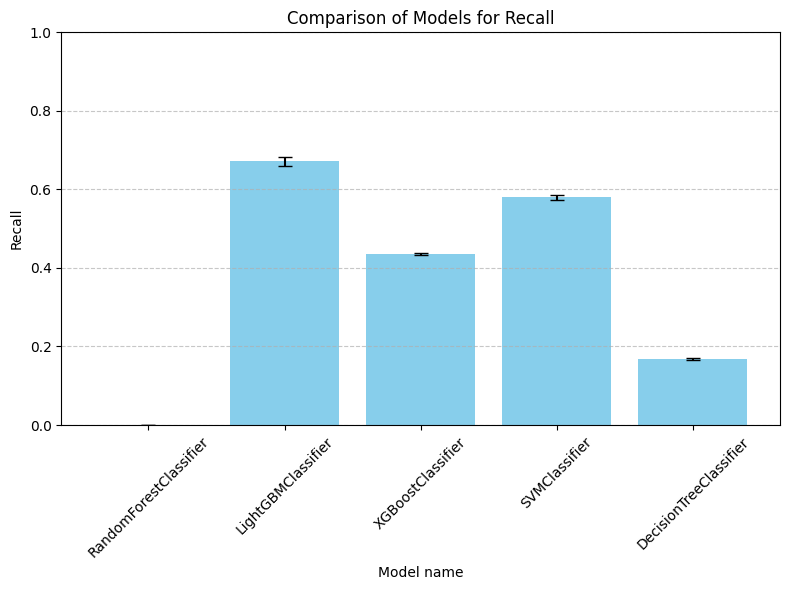

In [6]:
grouped_df = metrics_df.groupby('Metric name')

for metric, group in grouped_df:
    plt.figure(figsize=(8, 6))
    plt.bar(group['Model name'], group['Metric Mean value'], yerr=group['Metric Std value'], color='skyblue', capsize=5)
    plt.title(f'Comparison of Models for {metric}')
    plt.xlabel('Model name')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

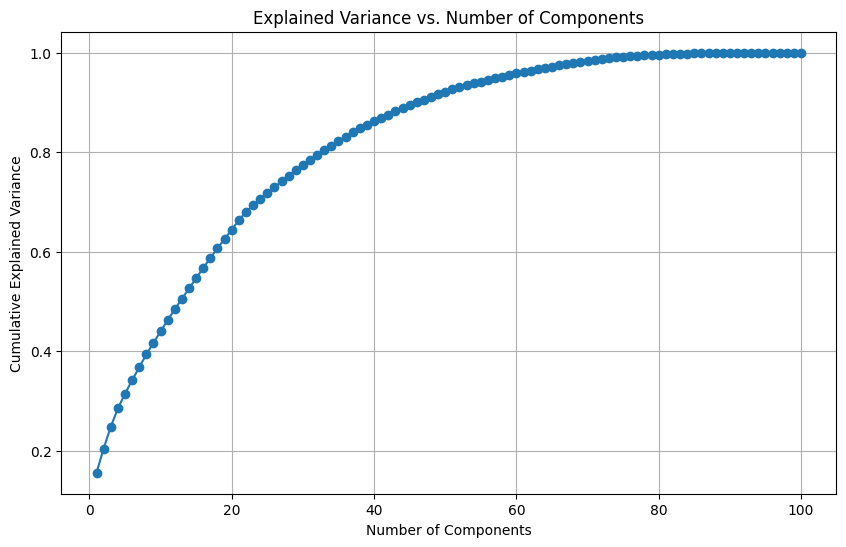

In [12]:
X_train = df[features_json["100"]]

# Assume X_train is your training data
pca = PCA().fit(X_train)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

In [44]:
x_input = df[features_json["100"]]
y_output = df['target']

ratio = float(y_output.value_counts()[0]) / y_output.value_counts()[1]

preprocessor = Pipeline([
    ('minmaxscaler', MinMaxScaler()),
    ('pca', PCA()),
    ('classifier', LGBMClassifier())
]
)

params = {'classifier__learning_rate': [0.001, 0.01, 0.1, 0.15],
        'classifier__n_estimators': [100, 200, 250, 300],
        'classifier__colsample_bytree': [0.25, 0.5, 0.75, 1],
        'pca__n_components': [80, 90, 100],
        'classifier__scale_pos_weight': [1, ratio, 2*ratio, 3*ratio],
        'classifier__verbose': [-1]
        }

grid_search = BayesSearchCV(estimator=preprocessor, search_spaces=params, cv=StratifiedKFold(n_splits=3), n_jobs=-1, scoring='roc_auc', random_state=42)

grid_search.fit(x_input, y_output.values.ravel())

print("\nBest Parameters according to BayesSearch for LightGBM:", grid_search.best_params_)

LGBM_results = pd.DataFrame(grid_search.cv_results_)



Best Parameters according to BayesSearch for LightGBM: OrderedDict([('classifier__colsample_bytree', 0.25), ('classifier__learning_rate', 0.1), ('classifier__n_estimators', 300), ('classifier__scale_pos_weight', 1), ('classifier__verbose', -1), ('pca__n_components', 100)])


In [45]:
LGBM_results.sort_values(by=["rank_test_score"], ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__n_estimators,param_classifier__scale_pos_weight,param_classifier__verbose,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
33,5.492957,0.238172,0.265863,0.040334,0.25,0.100,300,1.000000,-1,100,"{'classifier__colsample_bytree': 0.25, 'classi...",0.850682,0.855469,0.852399,0.852850,0.001980,1
45,4.490914,0.459329,0.192352,0.019397,0.25,0.100,250,1.000000,-1,100,"{'classifier__colsample_bytree': 0.25, 'classi...",0.850012,0.854912,0.851993,0.852306,0.002012,2
31,8.564816,0.746582,0.232988,0.037138,0.50,0.100,250,9.026319,-1,100,"{'classifier__colsample_bytree': 0.5, 'classif...",0.853108,0.852821,0.849373,0.851767,0.001697,3
40,5.899220,0.170795,0.459708,0.097032,0.25,0.100,300,9.026319,-1,100,"{'classifier__colsample_bytree': 0.25, 'classi...",0.850742,0.852171,0.850889,0.851267,0.000642,4
32,3.632132,0.194228,0.249127,0.061087,0.25,0.100,200,1.000000,-1,100,"{'classifier__colsample_bytree': 0.25, 'classi...",0.847646,0.854423,0.850414,0.850827,0.002782,5
16,4.624087,0.532255,0.279886,0.052992,0.25,0.100,200,9.026319,-1,100,"{'classifier__colsample_bytree': 0.25, 'classi...",0.849525,0.851998,0.849783,0.850435,0.001110,6
38,8.892808,0.691386,0.294150,0.061540,0.50,0.100,300,1.000000,-1,100,"{'classifier__colsample_bytree': 0.5, 'classif...",0.847887,0.850841,0.850747,0.849825,0.001371,7
26,7.435392,0.279308,0.302025,0.060685,0.75,0.100,200,9.026319,-1,100,"{'classifier__colsample_bytree': 0.75, 'classi...",0.848571,0.850166,0.847433,0.848723,0.001121,8
20,5.127489,0.229114,0.314582,0.036313,0.25,0.100,250,18.052639,-1,100,"{'classifier__colsample_bytree': 0.25, 'classi...",0.846716,0.849591,0.849352,0.848553,0.001303,9
41,5.900129,0.186429,0.282772,0.066490,0.50,0.100,200,1.000000,-1,100,"{'classifier__colsample_bytree': 0.5, 'classif...",0.847809,0.849142,0.848380,0.848444,0.000546,10


In [46]:
grid_search.best_params_

OrderedDict([('classifier__colsample_bytree', 0.25),
             ('classifier__learning_rate', 0.1),
             ('classifier__n_estimators', 300),
             ('classifier__scale_pos_weight', 1),
             ('classifier__verbose', -1),
             ('pca__n_components', 100)])

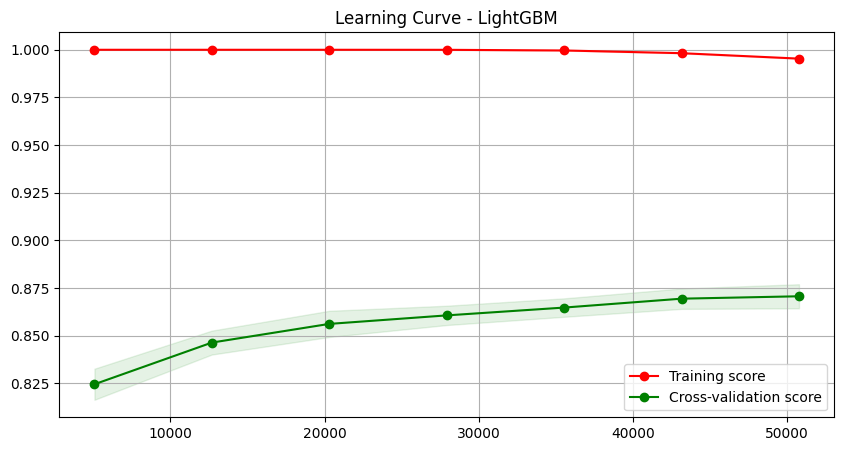


Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     10083
           1       0.74      0.27      0.39      1117

    accuracy                           0.92     11200
   macro avg       0.83      0.63      0.67     11200
weighted avg       0.91      0.92      0.90     11200



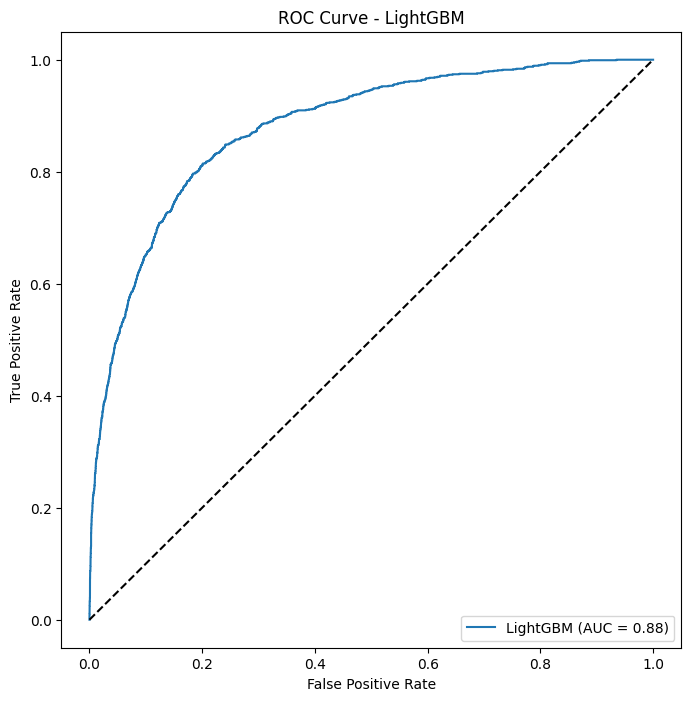


Confusion Matrix for LightGBM:

[[9976  107]
 [ 820  297]]


In [47]:
def plot_learning_curve(estimator, X, y, axes=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 7)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 5))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    axes.legend(loc="best")
    return plt


X = df[features_json["100"]]
y = df['target']

ratio = float(y.value_counts()[0]) / y.value_counts()[1]

preprocessor = Pipeline([
    ('minmaxscaler', MinMaxScaler()),
    ('classifier', LGBMClassifier(learning_rate=0.1,
                                  n_estimators= 300,
                                  scale_pos_weight=1,
                                  colsample_bytree=0.25,
                                  verbose=-1
                                 ))
]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=df["target"], random_state=42)

    
preprocessor.fit(X_train, y_train)


plot_learning_curve(preprocessor, X_train, y_train)
plt.title("Learning Curve - LightGBM")
plt.show()

y_pred = preprocessor.predict(X_test)


print("\nClassification Report for LightGBM:\n")
print(classification_report(y_test, y_pred))


fpr, tpr, thresholds = roc_curve(y_test, preprocessor.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {roc_auc_score(y_test, preprocessor.predict_proba(X_test)[:, 1]):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc='lower right')
plt.show()


print("\nConfusion Matrix for LightGBM:\n")
print(confusion_matrix(y_test, y_pred))

print("=" * 50)

Best Threshold: 0.1999473220550979


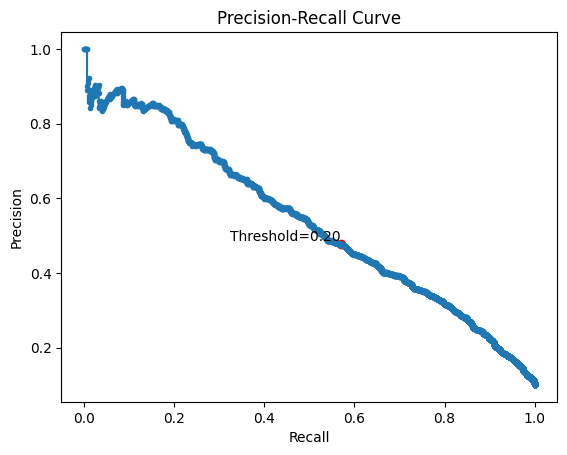

In [48]:
X = df[features_json["100"]]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=df["target"], random_state=42)

preprocessor = Pipeline([
    ('minmaxscaler', MinMaxScaler()),
    ('classifier', LGBMClassifier(learning_rate=0.1,
                                  n_estimators= 300,
                                  scale_pos_weight=1,
                                  colsample_bytree=0.25,
                                  verbose=-1
                                 ))
]
)

classifier = preprocessor.fit(X_train, y_train)

y_proba = classifier.predict_proba(X_test)[:, 1] 

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], color='red')
plt.text(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], f'Threshold={best_threshold:.2f}', verticalalignment='bottom', horizontalalignment='right')

print("Best Threshold:", best_threshold)
plt.show()


Classification Report

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     10083
           1       0.48      0.57      0.52      1117

    accuracy                           0.89     11200
   macro avg       0.71      0.75      0.73     11200
weighted avg       0.90      0.89      0.90     11200


Confusion Matrix

[[9386  697]
 [ 480  637]]


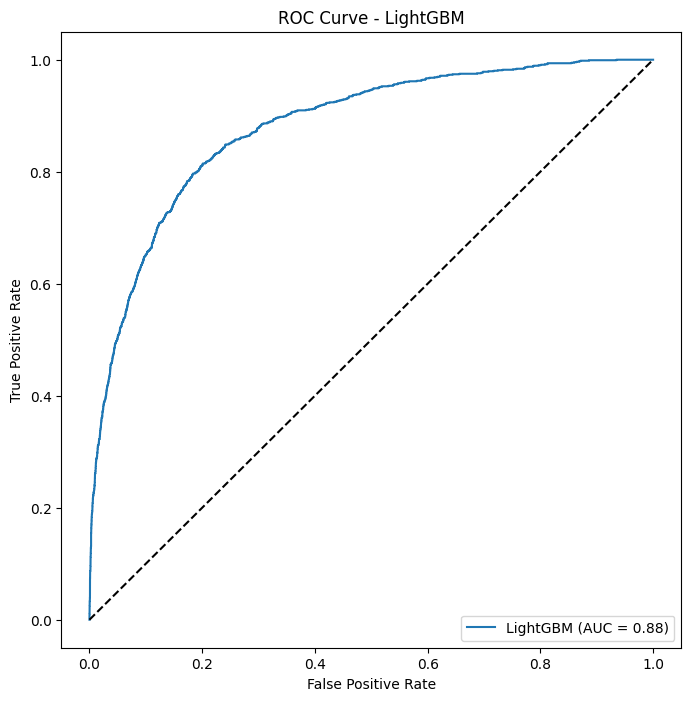

In [68]:
def lightgbm_clf(threshold, X, clf):
    y_proba = clf.predict_proba(X)[:, 1]
    y_pred = np.where(y_proba >= threshold, 1, 0)
    return y_pred

X = df[features_json["100"]]
y = df['target']

preprocessor = Pipeline([
    ('minmaxscaler', MinMaxScaler()),
    ('classifier', LGBMClassifier(learning_rate=0.1,
                                  n_estimators= 300,
                                  scale_pos_weight=1,
                                  colsample_bytree=0.25,
                                  verbose=-1
                                 ))
]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=df["target"], random_state=42)

preprocessor.fit(X_train, y_train)

y_pred = lightgbm_clf(0.199, X_test, clf=preprocessor)

print("\nClassification Report\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix\n")
print(confusion_matrix(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, preprocessor.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {roc_auc_score(y_test, preprocessor.predict_proba(X_test)[:, 1]):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc='lower right')
plt.show()

print("=" * 50)


Classification Report

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     11863
           1       0.46      0.56      0.50      1314

    accuracy                           0.89     13177
   macro avg       0.70      0.74      0.72     13177
weighted avg       0.90      0.89      0.90     13177


Confusion Matrix

[[11004   859]
 [  584   730]]


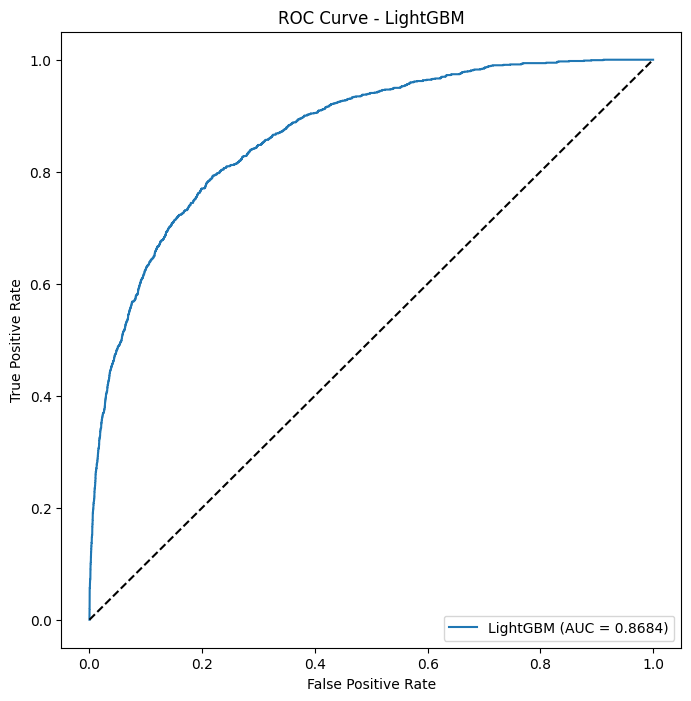

In [53]:
df_test = pd.read_csv(r"C:\Users\artur\Documents\bank-challenge-ml-project\testing_data_nb.csv")

X_test = df_test[features_json["100"]]
y_test = df_test['target']

X_train = df[features_json["100"]]
y_train = df['target']

preprocessor = Pipeline([
    ('minmaxscaler', MinMaxScaler()),
    ('classifier', LGBMClassifier(learning_rate=0.1,
                                  n_estimators= 300,
                                  scale_pos_weight=1,
                                  colsample_bytree=0.25,
                                  verbose=-1
                                 ))
]
)

preprocessor.fit(X_train, y_train)

y_pred = lightgbm_clf(0.199, X_test, clf=preprocessor)

print("\nClassification Report\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix\n")
print(confusion_matrix(y_test, y_pred))

print("=" * 50)

fpr, tpr, thresholds = roc_curve(y_test, preprocessor.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {roc_auc_score(y_test, preprocessor.predict_proba(X_test)[:, 1]):.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc='lower right')
plt.show()


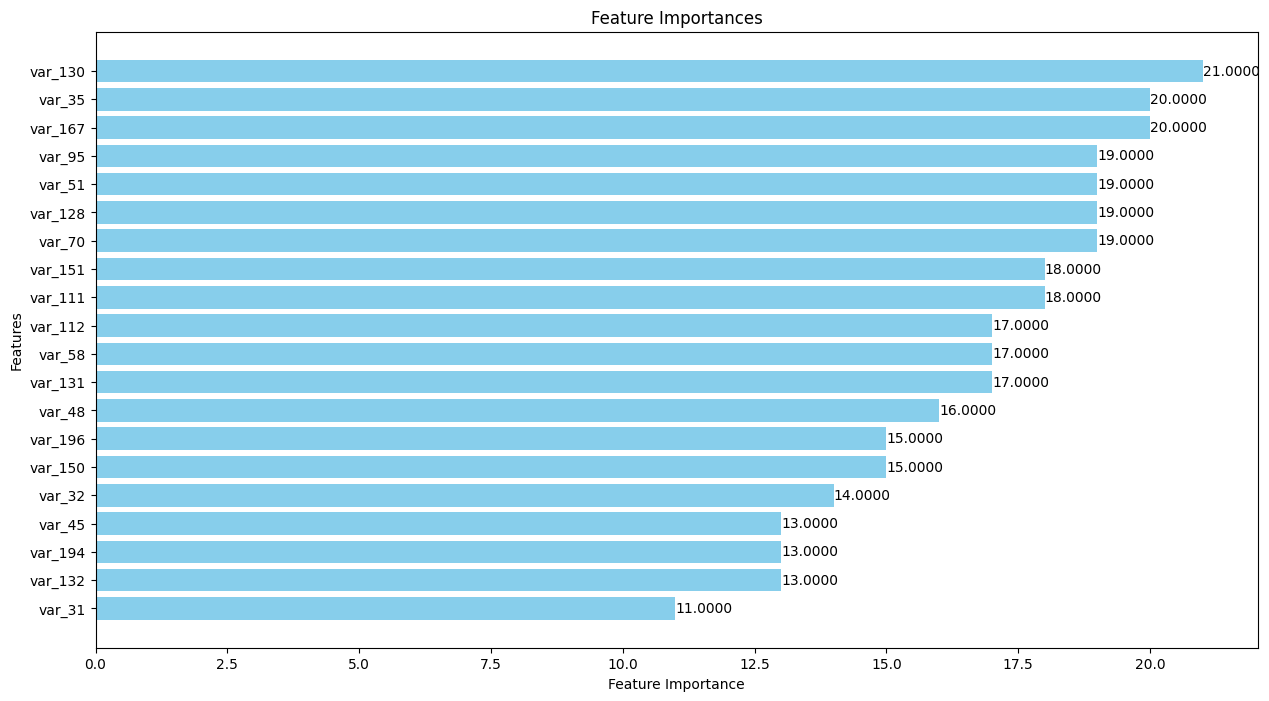

In [7]:
features_json = json.load(open('rfe_results.json'))

X = df[features_json["100"]]
y = df['target']

rf = LGBMClassifier(random_state=42, verbose=-1)
rf.fit(X, y)

feature_importances = rf.feature_importances_

features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=True).head(20)

plt.figure(figsize=(15, 8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')

for i, v in enumerate(features_df['Importance']):
    plt.text(v + 0.005, i, f'{v:.4f}', ha='left', va='center')

plt.show()